# DS 9000 Project

Dataset [here](https://www.kaggle.com/datasets/nasa/kepler-exoplanet-search-results)

In [37]:
#%load_ext jupyter_black

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#%matplotlib inline

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("cumulative.csv")
df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


## Summary of Columns
There are 50 columns in the dataset:

### Object Identification Columns
- `kepid`: The target ID, from the Kepler Input Catalog
- `kepoi_name`: Number used to identify a KOI (Kepler Object of Interest-- object that has exhibited at least one transit-like sequence)
- `kepler_name`: Name given once an object has been confirmed as a planet

### Target Variable
- `koi_disposition`: The category of the KOI according to the literature. (CANDIDATE, FALSE POSITIVE, NOT DISPOSITIONED, CONFIRMED)

### Project Disposition Columns
These columns are the result of Kepler data analysis.
- `koi_pdisposition`: The disposition Kepler data analysis has towards the candidate. (FALSE_POSITIVE, NOT_DISPOSITIONED, CANDIDATE)
- `koi_score`: The confidence in the `koi_pdisposition`. For CANDIDATE, a higher value indicates more confidence in the classification, whereas for FALSE POSITIVE, a higher value indicates less confidence in the disposition. ([0,1])
- `koi_fpflag_nt`: Not transit-like flag. Set when light curve is not consistent with planetary transit. (0 or 1)  
- `koi_fpflag_ss`: Stellar eclipse flag. Set when a significant secondary event is observed which indicates the transit-like event is most likely caused by an eclipsing binary. (0 or 1)
- `koi_fpflag_co`: Centroid offset flag. Set when the source of the signal is from a nearby star (0 or 1).
- `koi_fpflag_ec`: Ephemeris match indicates contamination flag. Set when the KOI has the same period and epoch as another object and is judged to be the result of contamination. (0 or 1)

### Transit Properties
These are physical properties of the stellar transit observed by Kepler
- `koi_period`: Interval between consecutive planetary transits (in days)       
- `koi_period_err1`: Positive uncertainty on `koi_period`
- `koi_period_err2`: Negative uncertainty on `koi_period`
- `koi_time0bk`: Time corresponding to the centre of the first detected transit, minus a constant, in Barycentric Julian Day 
- `koi_time0bk_err1`: Positive uncertainty on `koi_time0bk`
- `koi_time0bk_err2`: Negative uncertainty on `koi_time0bk`
- `koi_impact`: The sky-projected distance between the centre of the stellar disk and the centre of the planet disk at conjunction, normalized by the stellar radius       
- `koi_impact_err1`: Positive uncertainty on `koi_impact`
- `koi_impact_err2`: Negative uncertainty on `koi_impact`
- `koi_duration`: Transit duration in hours.   
- `koi_duration_err1`: Positive uncertainty in transit duration.
- `koi_duration_err2`: Negative uncertainty in transit duration.
- `koi_depth`: The fraction of stellar flux lost at the minimum of planetary transit (ppm)
- `koi_depth_err1`: Positive uncertainty on `koi_depth`
- `koi_depth_err2`: Negative uncertainty on `koi_depth`
- `koi_prad`: Planetary radius (Earth radii)  
- `koi_prad_err1`: Positive uncertainty on `koi_prad`    
- `koi_prad_err2`: Negative uncertainty on `koi_prad`
- `koi_teq`: Approximation for temperature of the planet (Kelvin)
- `koi_teq_err1`: Positive uncertainty on `koi_teq`
- `koi_teq_err2`: Negative uncertainty on `koi_teq`
- `koi_insol`: Insolation flux (Earth flux)
- `koi_insol_err1`: Positive uncertainty on `koi_insol`
- `koi_insol_err2`: Negative uncertainty on `koi_insol`

### Threshold Crossing Event (TCE) Information
- `koi_model_snr`: Transit signal-to-noise ratio    
- `koi_tce_plnt_num`: TCE planet number federated to the KOI*
- `koi_tce_delivname`: TCE delivery name corresponding to the TCE data federated to the KOI*

### Stellar Parameters
- `koi_steff`: The photospheric temperature of the star (Kelvin)        
- `koi_steff_err1`: Positive uncertainty on `koi_steff`
- `koi_steff_err2`: Negative uncertainty on `koi_steff`
- `koi_slogg`: Base 10 logarithm of the star's surface gravity ($log_{10}(cm/s^2)$) 
- `koi_slogg_err1`: Positive uncertainty on `koi_slogg`
- `koi_slogg_err2`: Negative uncertainty on `koi_slogg`
- `koi_srad`: Stellar radius (solar radii)
- `koi_srad_err1`: Positive uncertainty on `koi_srad`
- `koi_srad_err2`: Negative uncertainty on `koi_srad`

### KIC Parameters
- `ra`: KIC Right Ascension (degrees)
- `dec`: KIC Declination (degrees)
- `koi_kepmag`: Kepler-band (magnitude)

We are interested only in parameters related to the physical properties of the transit. As such, we can drop the object identification columns, `koi_tce_plnt_num`, `koi_tce_delivname`, `ra`, and `dec`. We'll also drop `koi_pdisposition`, `koi_score`, and `koi_fpflag_nt`, as these are the product of Kepler's data analysis and not directly related to the physical properties of the transit. We'll keep the `koi_fpflag_ss`, `koi_fpflag_co`, `koi_fpflag_ec` as they describe properties of the light curve and their inclusion may improve model performance.

In [3]:
drop_cols = [
    "rowid",
    "kepid",
    "kepoi_name",
    "kepler_name",
    "koi_pdisposition",
    "koi_score",
    "koi_fpflag_nt",
    "koi_tce_plnt_num",
    "koi_tce_delivname",
    "ra",
    "dec",
]

df = df.drop(drop_cols, axis=1, errors="ignore")

# Basic info on data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   koi_disposition    9564 non-null   object 
 1   koi_fpflag_ss      9564 non-null   int64  
 2   koi_fpflag_co      9564 non-null   int64  
 3   koi_fpflag_ec      9564 non-null   int64  
 4   koi_period         9564 non-null   float64
 5   koi_period_err1    9110 non-null   float64
 6   koi_period_err2    9110 non-null   float64
 7   koi_time0bk        9564 non-null   float64
 8   koi_time0bk_err1   9110 non-null   float64
 9   koi_time0bk_err2   9110 non-null   float64
 10  koi_impact         9201 non-null   float64
 11  koi_impact_err1    9110 non-null   float64
 12  koi_impact_err2    9110 non-null   float64
 13  koi_duration       9564 non-null   float64
 14  koi_duration_err1  9110 non-null   float64
 15  koi_duration_err2  9110 non-null   float64
 16  koi_depth          9201 

From the output above, we can see that `koi_teq_err1` and `koi_teq_err2` are both empty columns. We'll drop those.

In [4]:
df = df.drop(["koi_teq_err1", "koi_teq_err2"], axis=1, errors="ignore")
df.head()

,koi_disposition,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,...,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_kepmag
0,CONFIRMED,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,...,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,15.347
1,CONFIRMED,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,...,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,15.347
2,FALSE POSITIVE,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,...,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,15.436
3,FALSE POSITIVE,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,...,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,15.597
4,CONFIRMED,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,...,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,15.509


# Exploratory Data Analysis

## Summary Statistics

In [5]:
print("df.describe() for all KOI (Kepler Objects of Interest):")
display(df.describe().map("{:.3f}".format))

# Grouped df.describe() by planet disposition (confirmed, false positive, or candidate)
for disposition, group in df.groupby("koi_disposition", observed=True):
    print(f"\nSummary statistics for KOIs with disposition: {disposition}")
    display(group.describe().map("{:.3f}".format))

df.describe() for all KOI (Kepler Objects of Interest):


,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,...,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_kepmag
count,9564.000,9564.000,9564.000,9564.000,9110.000,9110.000,9564.000,9110.000,9110.000,9201.000,...,9201.000,9096.000,9081.000,9201.000,9096.000,9096.000,9201.000,9096.000,9096.000,9563.000
mean,0.232,0.195,0.120,75.671,0.002,-0.002,166.183,0.010,-0.010,0.735,...,5706.823,144.636,-162.265,4.310,0.121,-0.143,1.729,0.362,-0.395,14.265
std,0.422,0.396,0.325,1334.744,0.008,0.008,67.919,0.023,0.023,3.349,...,796.858,47.052,72.746,0.433,0.133,0.085,6.127,0.931,2.168,1.385
min,0.000,0.000,0.000,0.242,0.000,-0.172,120.516,0.000,-0.569,0.000,...,2661.000,0.000,-1762.000,0.047,0.000,-1.207,0.109,0.000,-116.137,6.966
25%,0.000,0.000,0.000,2.734,0.000,-0.000,132.762,0.001,-0.011,0.197,...,5310.000,106.000,-198.000,4.218,0.042,-0.196,0.829,0.129,-0.250,13.440
50%,0.000,0.000,0.000,9.753,0.000,-0.000,137.225,0.004,-0.004,0.537,...,5767.000,157.000,-160.000,4.438,0.070,-0.128,1.000,0.251,-0.111,14.520
75%,0.000,0.000,0.000,40.715,0.000,-0.000,170.695,0.011,-0.001,0.889,...,6112.000,174.000,-114.000,4.543,0.149,-0.088,1.345,0.364,-0.069,15.322
max,1.000,1.000,1.000,129995.778,0.172,0.000,1472.522,0.569,-0.000,100.806,...,15896.000,676.000,0.000,5.364,1.472,0.000,229.908,33.091,0.000,20.003



Summary statistics for KOIs with disposition: CANDIDATE


,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,...,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_kepmag
count,2248.000,2248.000,2248.000,2248.000,2171.000,2171.000,2248.000,2171.000,2171.000,2185.000,...,2185.000,2177.000,2177.000,2185.000,2177.000,2177.000,2185.000,2177.000,2177.000,2248.000
mean,0.014,0.000,0.000,130.524,0.002,-0.002,170.431,0.013,-0.013,0.537,...,5639.767,139.563,-153.668,4.331,0.115,-0.145,1.566,0.328,-0.322,14.338
std,0.118,0.000,0.000,2744.156,0.007,0.007,74.697,0.027,0.027,1.990,...,693.971,46.075,61.521,0.391,0.128,0.091,5.875,0.590,1.830,1.311
min,0.000,0.000,0.000,0.260,0.000,-0.142,129.730,0.000,-0.488,0.000,...,2661.000,0.000,-941.000,0.114,0.000,-1.207,0.109,0.000,-76.199,7.748
25%,0.000,0.000,0.000,5.108,0.000,-0.001,133.555,0.004,-0.014,0.147,...,5273.000,99.000,-192.000,4.248,0.042,-0.200,0.826,0.129,-0.217,13.570
50%,0.000,0.000,0.000,13.279,0.000,-0.000,138.475,0.008,-0.008,0.396,...,5729.000,154.000,-154.000,4.444,0.067,-0.125,0.990,0.244,-0.107,14.650
75%,0.000,0.000,0.000,59.304,0.001,-0.000,169.598,0.014,-0.004,0.770,...,6068.000,171.000,-102.000,4.544,0.141,-0.085,1.286,0.357,-0.068,15.367
max,1.000,0.000,0.000,129995.778,0.142,0.000,907.045,0.488,-0.000,64.516,...,10894.000,560.000,0.000,5.364,1.232,0.000,152.969,15.454,0.000,17.305



Summary statistics for KOIs with disposition: CONFIRMED


,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,...,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_kepmag
count,2293.000,2293.000,2293.000,2293.000,2292.000,2292.000,2293.000,2292.000,2292.000,2292.000,...,2292.000,2292.000,2279.000,2292.000,2292.000,2292.000,2292.000,2292.000,2292.000,2293.000
mean,0.011,0.003,0.000,27.063,0.000,-0.000,157.263,0.004,-0.004,0.427,...,5477.974,116.873,-124.185,4.411,0.090,-0.106,1.067,0.175,-0.150,14.337
std,0.106,0.051,0.021,54.019,0.001,0.001,42.479,0.010,0.010,0.332,...,677.133,43.070,52.078,0.235,0.079,0.065,0.643,0.143,0.225,1.227
min,0.000,0.000,0.000,0.342,0.000,-0.051,120.566,0.000,-0.345,0.000,...,2703.000,0.000,-712.000,2.410,0.000,-0.748,0.118,0.000,-4.943,8.224
25%,0.000,0.000,0.000,5.083,0.000,-0.000,134.206,0.001,-0.005,0.081,...,5171.000,82.000,-152.000,4.287,0.036,-0.126,0.808,0.066,-0.161,13.659
50%,0.000,0.000,0.000,11.323,0.000,-0.000,140.530,0.003,-0.003,0.393,...,5616.000,107.000,-112.000,4.455,0.064,-0.105,0.968,0.160,-0.089,14.590
75%,0.000,0.000,0.000,25.517,0.000,-0.000,171.304,0.005,-0.001,0.746,...,5929.500,153.000,-83.000,4.557,0.130,-0.052,1.200,0.243,-0.055,15.258
max,1.000,1.000,1.000,1071.233,0.051,-0.000,589.720,0.345,-0.000,1.300,...,9565.000,676.000,0.000,5.274,0.765,0.000,19.530,2.551,0.000,17.475



Summary statistics for KOIs with disposition: FALSE POSITIVE


,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,...,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_kepmag
count,5023.000,5023.000,5023.000,5023.000,4647.000,4647.000,5023.000,4647.000,4647.000,4724.000,...,4724.000,4627.000,4625.000,4724.000,4627.000,4627.000,4724.000,4627.000,4627.000,5022.000
mean,0.429,0.370,0.228,73.312,0.003,-0.003,168.354,0.011,-0.011,0.976,...,5848.873,160.775,-185.076,4.251,0.139,-0.161,2.125,0.471,-0.550,14.199
std,0.495,0.483,0.420,139.114,0.010,0.010,73.587,0.025,0.025,4.454,...,862.615,42.201,77.490,0.508,0.152,0.086,7.522,1.225,2.754,1.480
min,0.000,0.000,0.000,0.242,0.000,-0.172,120.516,0.000,-0.569,0.000,...,2661.000,0.000,-1762.000,0.047,0.000,-1.007,0.116,0.000,-116.137,6.966
25%,0.000,0.000,0.000,1.507,0.000,-0.000,132.204,0.000,-0.013,0.314,...,5398.000,151.500,-210.000,4.130,0.046,-0.204,0.845,0.194,-0.386,13.314
50%,0.000,0.000,0.000,6.383,0.000,-0.000,134.890,0.004,-0.004,0.656,...,5855.000,165.000,-179.000,4.433,0.074,-0.168,1.009,0.305,-0.123,14.408
75%,1.000,1.000,0.000,49.402,0.000,-0.000,170.193,0.013,-0.000,1.004,...,6225.000,181.000,-151.000,4.536,0.177,-0.105,1.548,0.431,-0.078,15.328
max,1.000,1.000,1.000,1064.268,0.172,-0.000,1472.522,0.569,-0.000,100.806,...,15896.000,595.000,0.000,5.283,1.472,0.000,229.908,33.091,0.000,20.003


In [6]:
# Information on the null values in the columns
df.isnull().sum()

koi_disposition        0
koi_fpflag_ss          0
koi_fpflag_co          0
koi_fpflag_ec          0
koi_period             0
koi_period_err1      454
koi_period_err2      454
koi_time0bk            0
koi_time0bk_err1     454
koi_time0bk_err2     454
koi_impact           363
koi_impact_err1      454
koi_impact_err2      454
koi_duration           0
koi_duration_err1    454
koi_duration_err2    454
koi_depth            363
koi_depth_err1       454
koi_depth_err2       454
koi_prad             363
koi_prad_err1        363
koi_prad_err2        363
koi_teq              363
koi_insol            321
koi_insol_err1       321
koi_insol_err2       321
koi_model_snr        363
koi_steff            363
koi_steff_err1       468
koi_steff_err2       483
koi_slogg            363
koi_slogg_err1       468
koi_slogg_err2       468
koi_srad             363
koi_srad_err1        468
koi_srad_err2        468
koi_kepmag             1
dtype: int64

## Correlation Heatmap
To identify any potentially important features, and note any strong correlations between features, we plot the Pearson correlation as a heatmap. Note that we only include the base measurements here, and not their error terms.

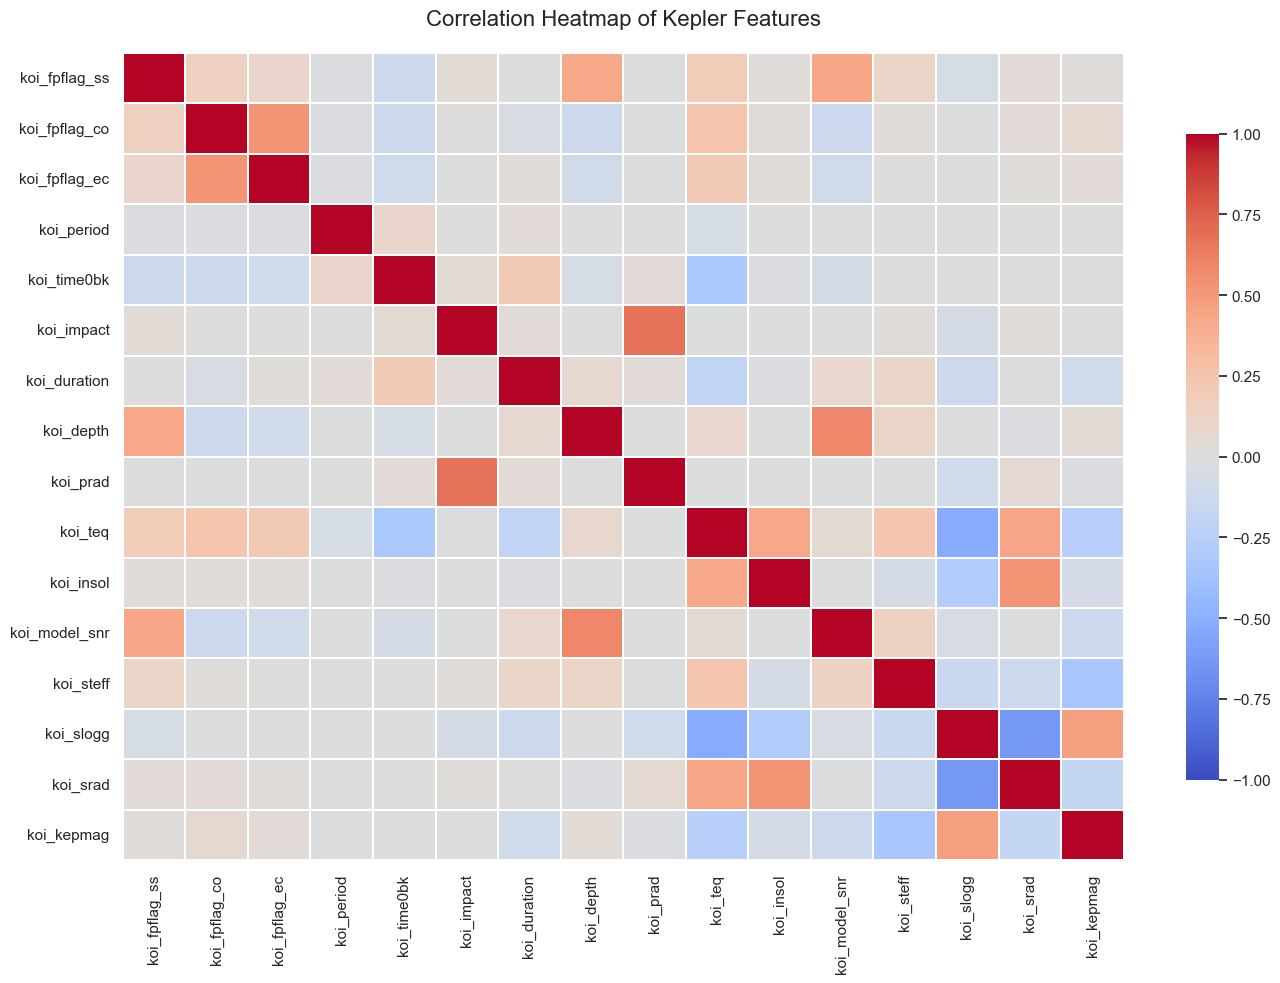

In [7]:
numeric_df = df.loc[:, ~df.columns.str.contains("err", case=False)].select_dtypes(
    include=["float64", "int64"]
)

corr_matrix = numeric_df.corr(method="pearson")

plt.figure(figsize=(14, 10))
sns.set(style="white")

heatmap = sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    annot=False,
    linewidths=0.3,
    cbar_kws={"shrink": 0.8},
)


plt.title("Correlation Heatmap of Kepler Features", fontsize=16, pad=20)

plt.tight_layout()
plt.show()

Remaining Exploratory Data Analysis in this section

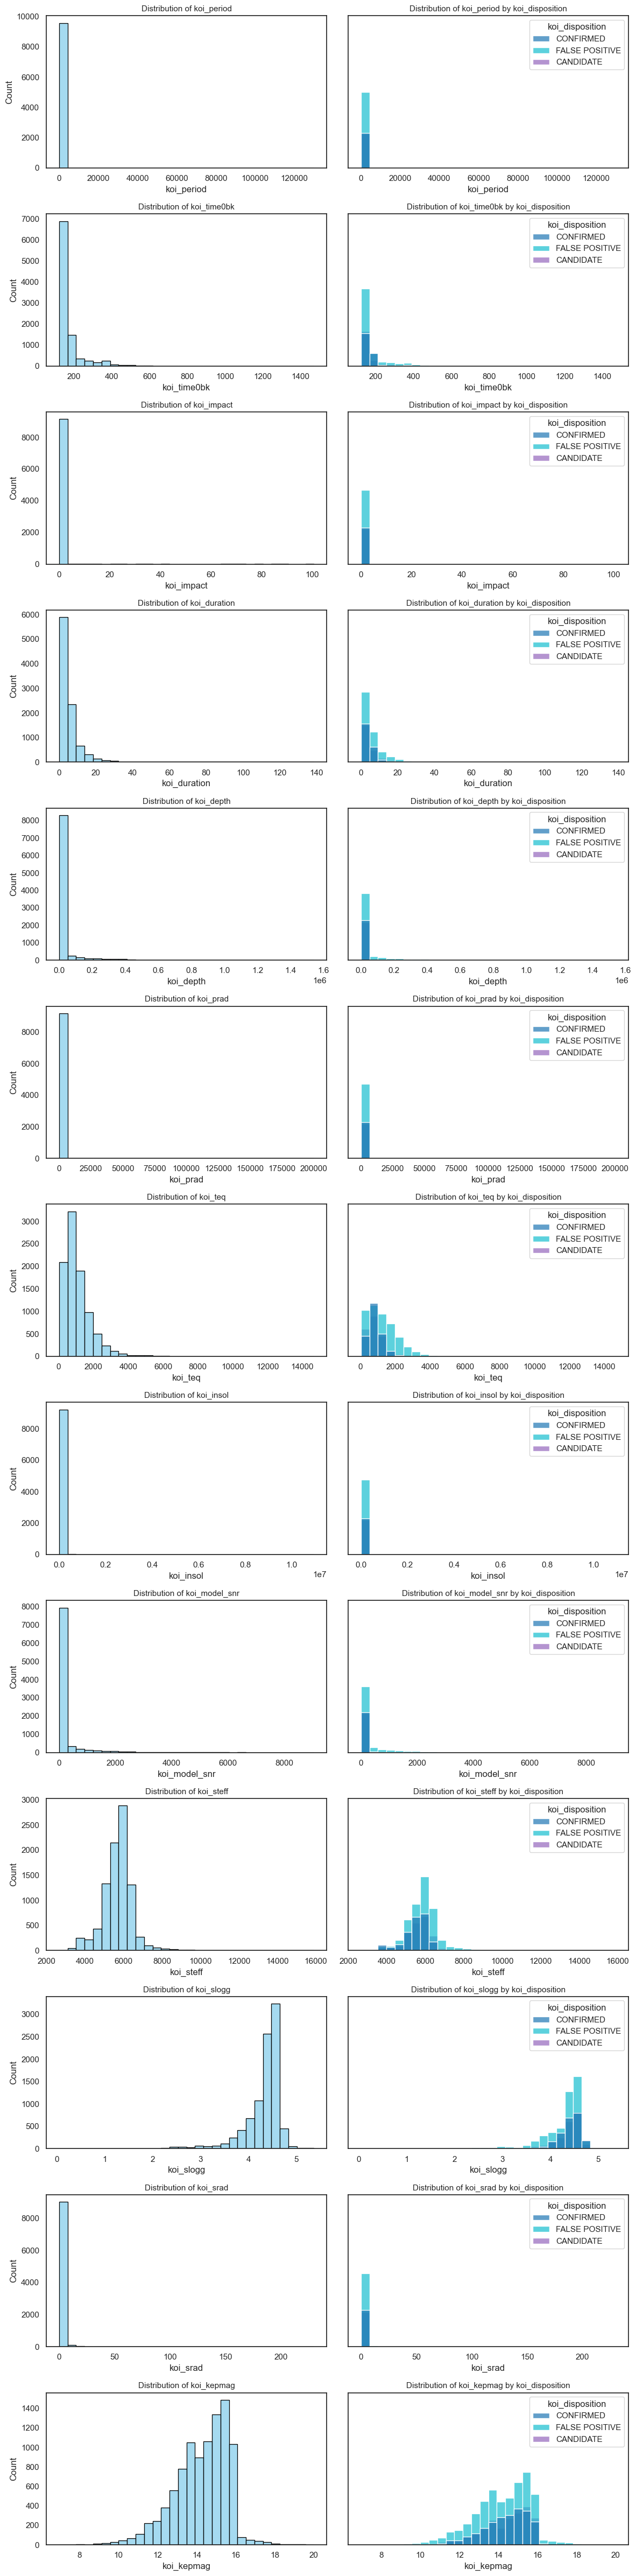

In [8]:
# column of interests
numerical_cols = [
    "koi_period",
    "koi_time0bk",
    "koi_impact",
    "koi_duration",
    "koi_depth",
    "koi_prad",
    "koi_teq",
    "koi_insol",
    "koi_model_snr",
    "koi_steff",
    "koi_slogg",
    "koi_srad",
    "koi_kepmag",
]

# colors
palette = {"CONFIRMED": "#1f77b4", "FALSE POSITIVE": "#17becf", "CANDIDATE": "#9467bd"}

# 13 * 2 subplots
fig, axs = plt.subplots(
    nrows=len(numerical_cols), ncols=2, figsize=(12, 48), sharey="row"
)

for i, col in enumerate(numerical_cols):
    # first column - overall distribution
    sns.histplot(df, x=col, bins=30, ax=axs[i, 0], color="skyblue", edgecolor="black")
    axs[i, 0].set_title(f"Distribution of {col}", fontsize=11)
    axs[i, 0].set_xlabel(col)
    axs[i, 0].set_ylabel("Count")

    # second column - koi_disposition - ['CONFIRMED', 'FALSE POSITIVE', 'CANDIDATE']
    sns.histplot(
        df,
        x=col,
        hue="koi_disposition",
        bins=30,
        ax=axs[i, 1],
        alpha=0.7,
        palette=palette,
    )
    axs[i, 1].set_title(f"Distribution of {col} by koi_disposition", fontsize=11)
    axs[i, 1].set_xlabel(col)
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

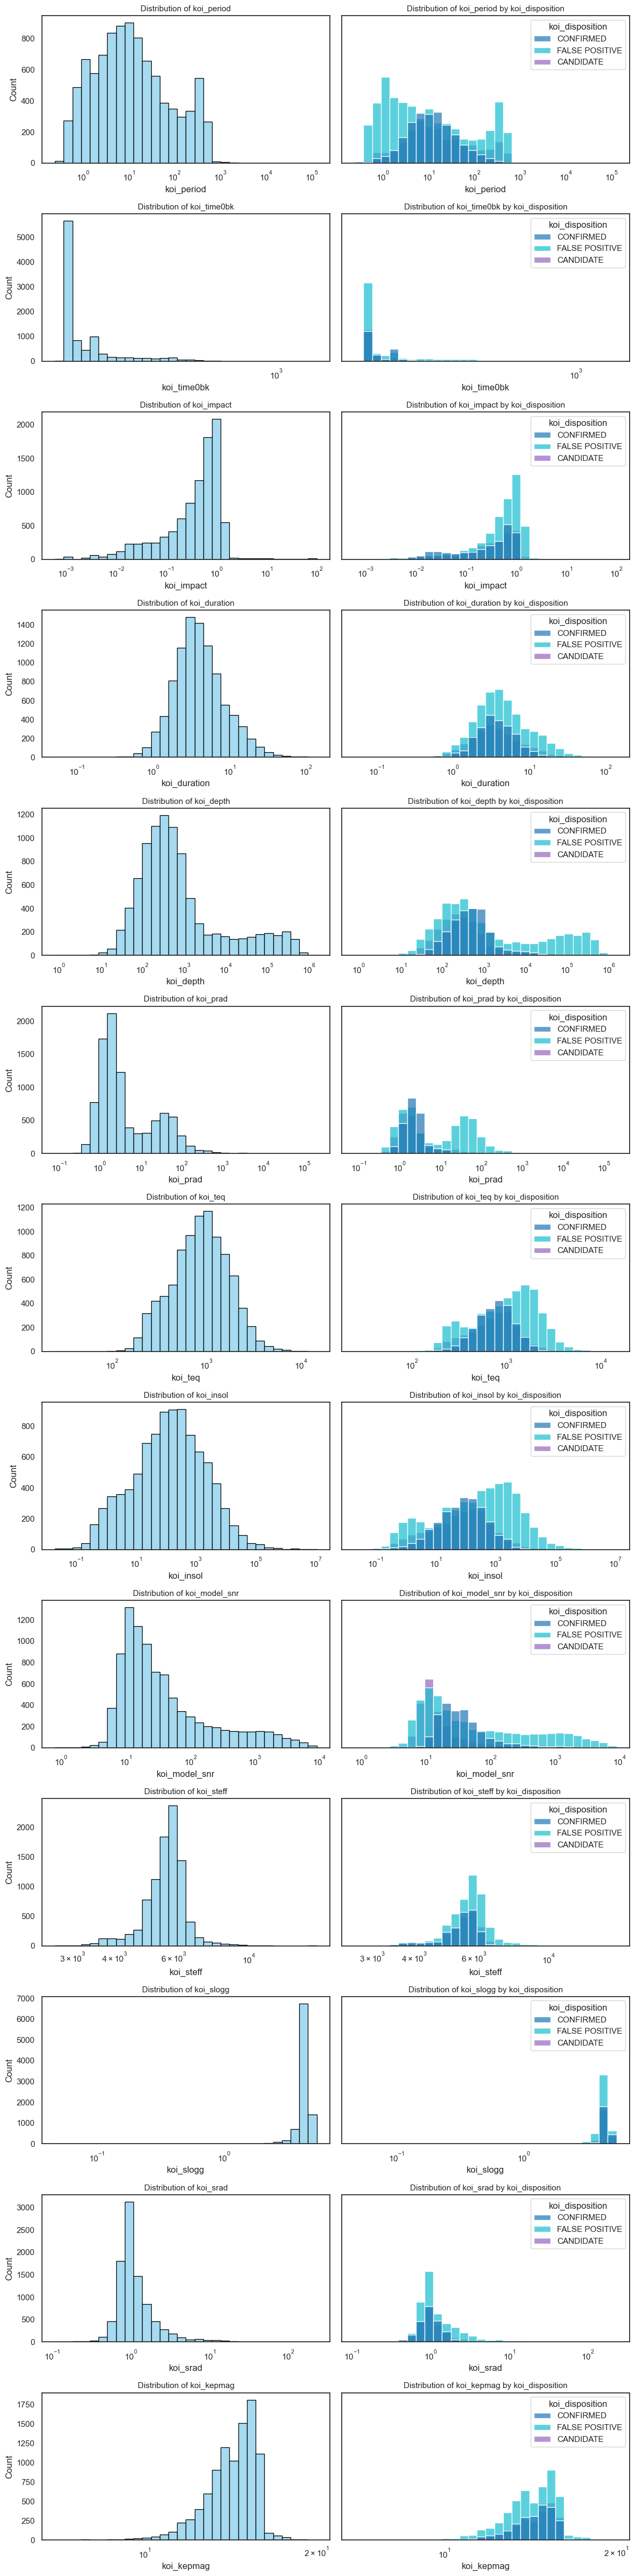

In [9]:
# log scale
# need to filter out only positive values
numerical_cols = [
    "koi_period",
    "koi_time0bk",
    "koi_impact",
    "koi_duration",
    "koi_depth",
    "koi_prad",
    "koi_teq",
    "koi_insol",
    "koi_model_snr",
    "koi_steff",
    "koi_slogg",
    "koi_srad",
    "koi_kepmag",
]

palette = {"CONFIRMED": "#1f77b4", "FALSE POSITIVE": "#17becf", "CANDIDATE": "#9467bd"}

fig, axs = plt.subplots(
    nrows=len(numerical_cols), ncols=2, figsize=(12, 48), sharey="row"
)

for i, col in enumerate(numerical_cols):
    # remove non-positive values to allow log scale
    df_pos = df[df[col] > 0]

    # first column - overall distribution
    sns.histplot(
        df_pos,
        x=col,
        bins=30,
        ax=axs[i, 0],
        color="skyblue",
        edgecolor="black",
        log_scale=True,
    )
    axs[i, 0].set_title(f"Distribution of {col}", fontsize=11)
    axs[i, 0].set_xlabel(col)
    axs[i, 0].set_ylabel("Count")

    # second column - koi_disposition
    sns.histplot(
        df_pos,
        x=col,
        hue="koi_disposition",
        bins=30,
        ax=axs[i, 1],
        alpha=0.7,
        palette=palette,
        log_scale=True,
    )
    axs[i, 1].set_title(f"Distribution of {col} by koi_disposition", fontsize=11)
    axs[i, 1].set_xlabel(col)
    axs[i, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

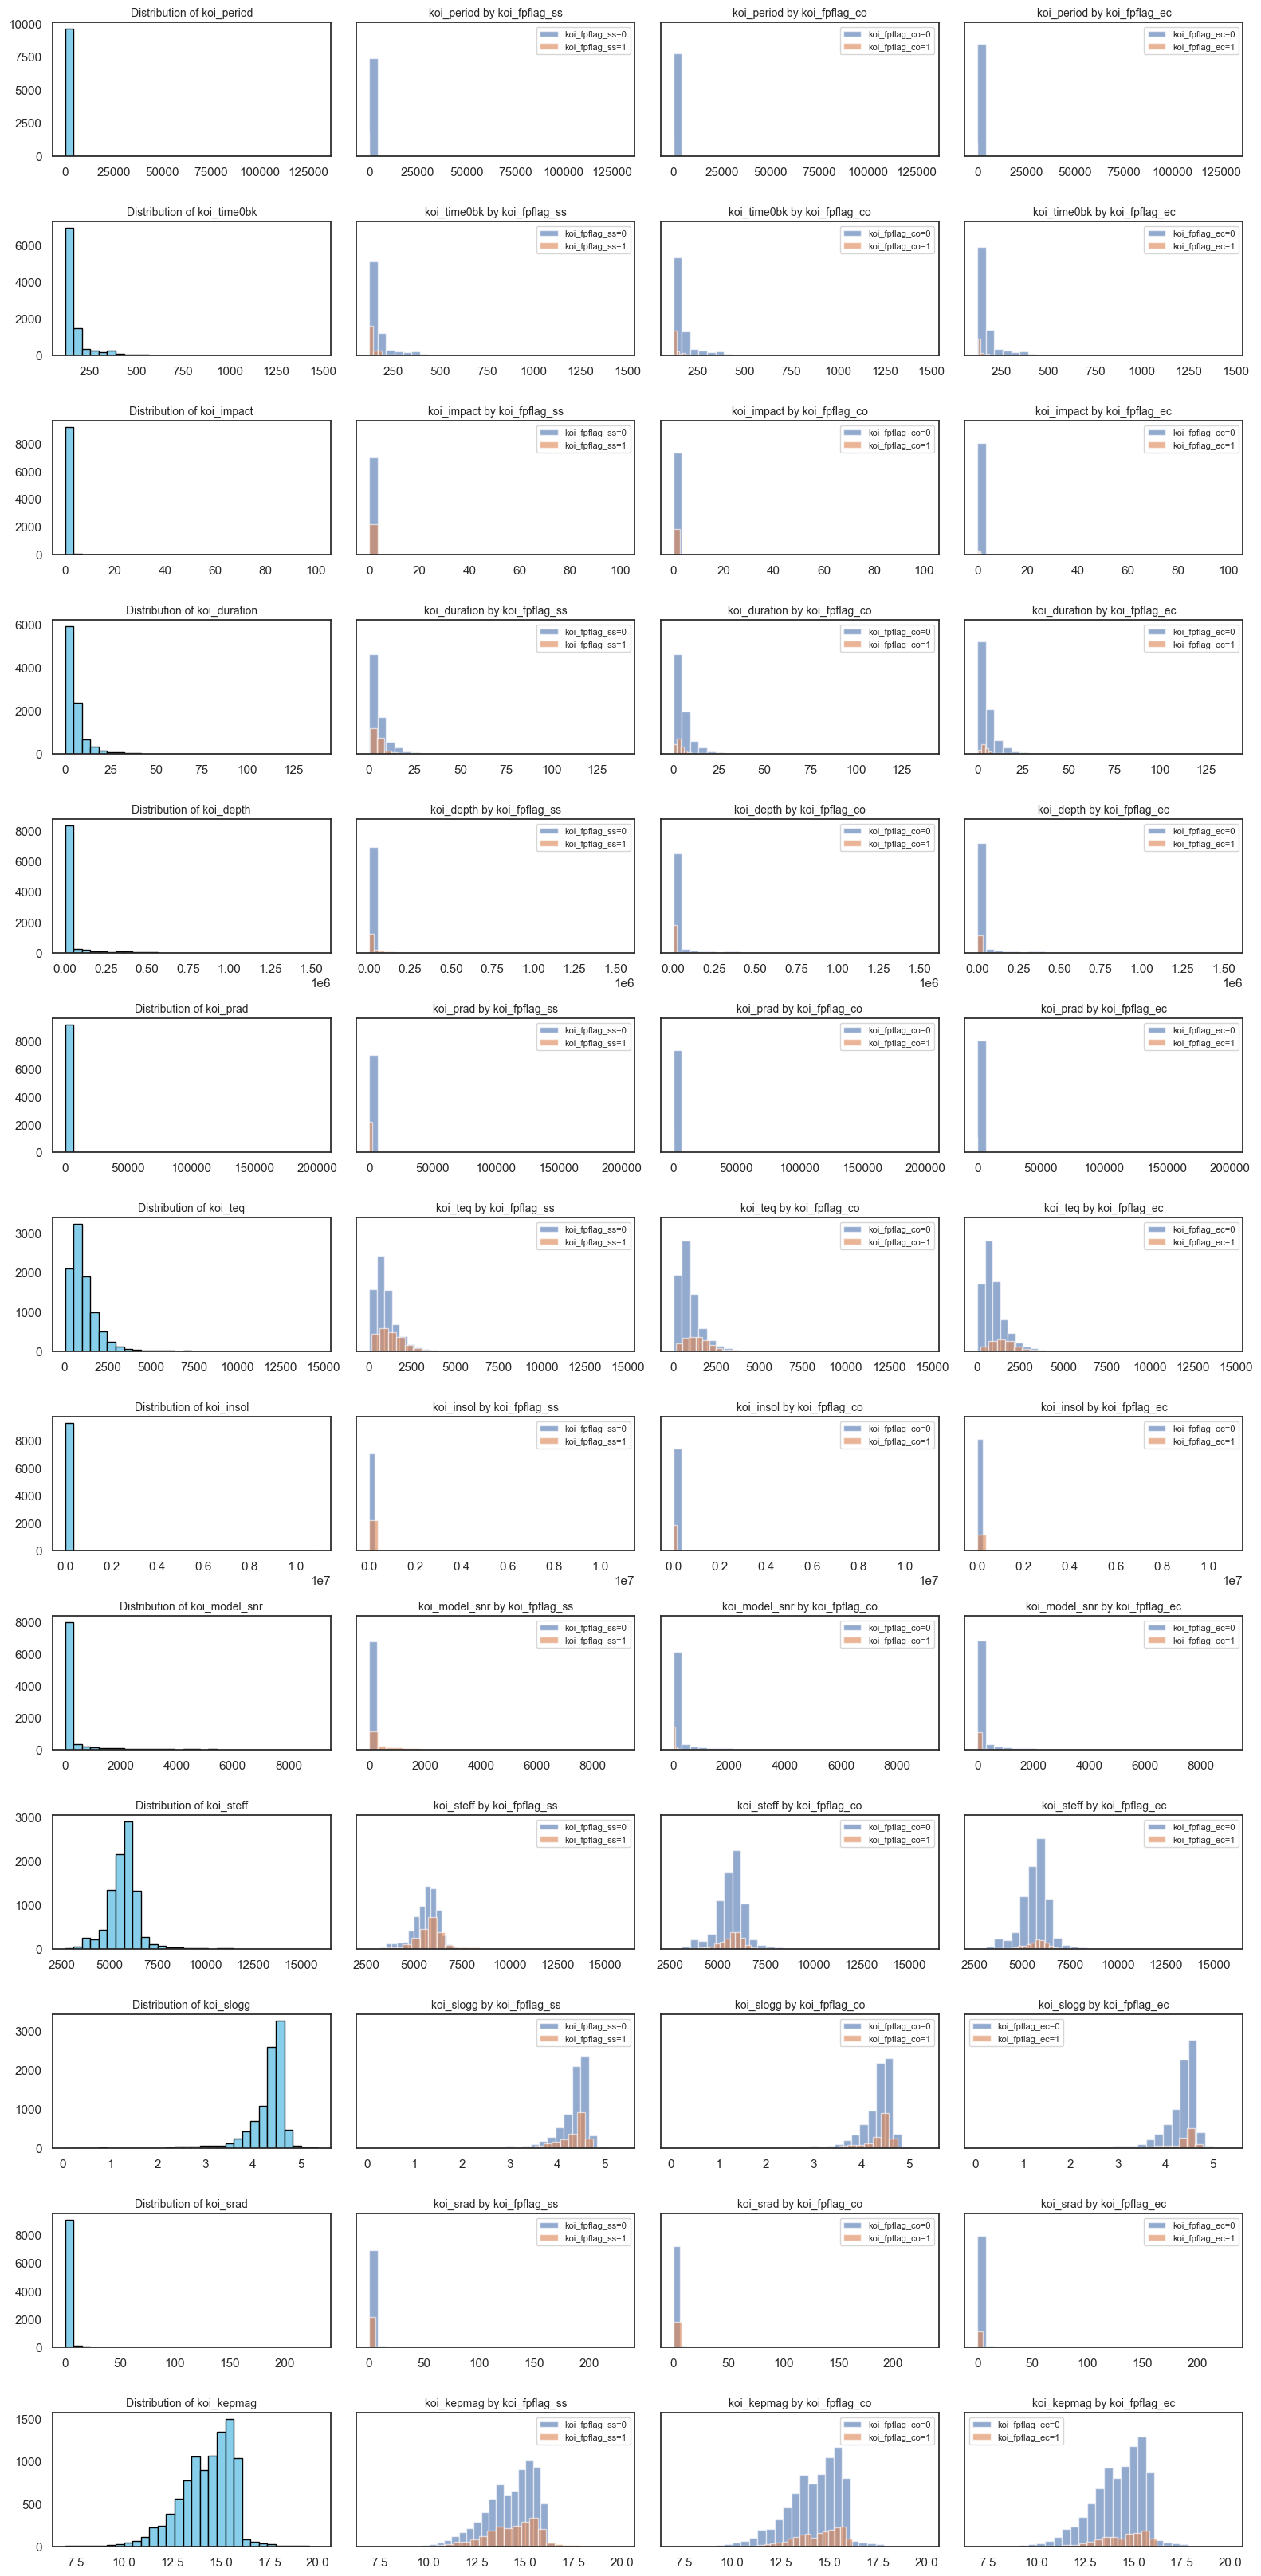

In [10]:
numerical_cols = [
    "koi_period",
    "koi_time0bk",
    "koi_impact",
    "koi_duration",
    "koi_depth",
    "koi_prad",
    "koi_teq",
    "koi_insol",
    "koi_model_snr",
    "koi_steff",
    "koi_slogg",
    "koi_srad",
    "koi_kepmag",
]

flag_cols = ["koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec"]

# 13 rows × 4 columns
fig, axs = plt.subplots(
    nrows=len(numerical_cols),
    ncols=4,
    figsize=(16, 2.5 * len(numerical_cols)),
    sharey="row",
    squeeze=False,
)

for i, col in enumerate(numerical_cols):
    # first column - overall distribution
    ax = axs[i, 0]
    ax.hist(df[col].dropna(), bins=30, color="skyblue", edgecolor="black")
    ax.set_title(f"Distribution of {col}", fontsize=10)

    # column 2 - 4 - with flags
    for j, flag in enumerate(flag_cols, start=1):
        ax = axs[i, j]

        for val in sorted(df[flag].dropna().unique()):
            subset = df[df[flag] == val][col]
            ax.hist(subset, bins=30, alpha=0.6, label=f"{flag}={val}")
        ax.legend(fontsize=8)
        ax.set_title(f"{col} by {flag}", fontsize=10)

plt.tight_layout()

# plt.savefig("kepler_histograms_fast.png", dpi=150, bbox_inches="tight")
plt.show()

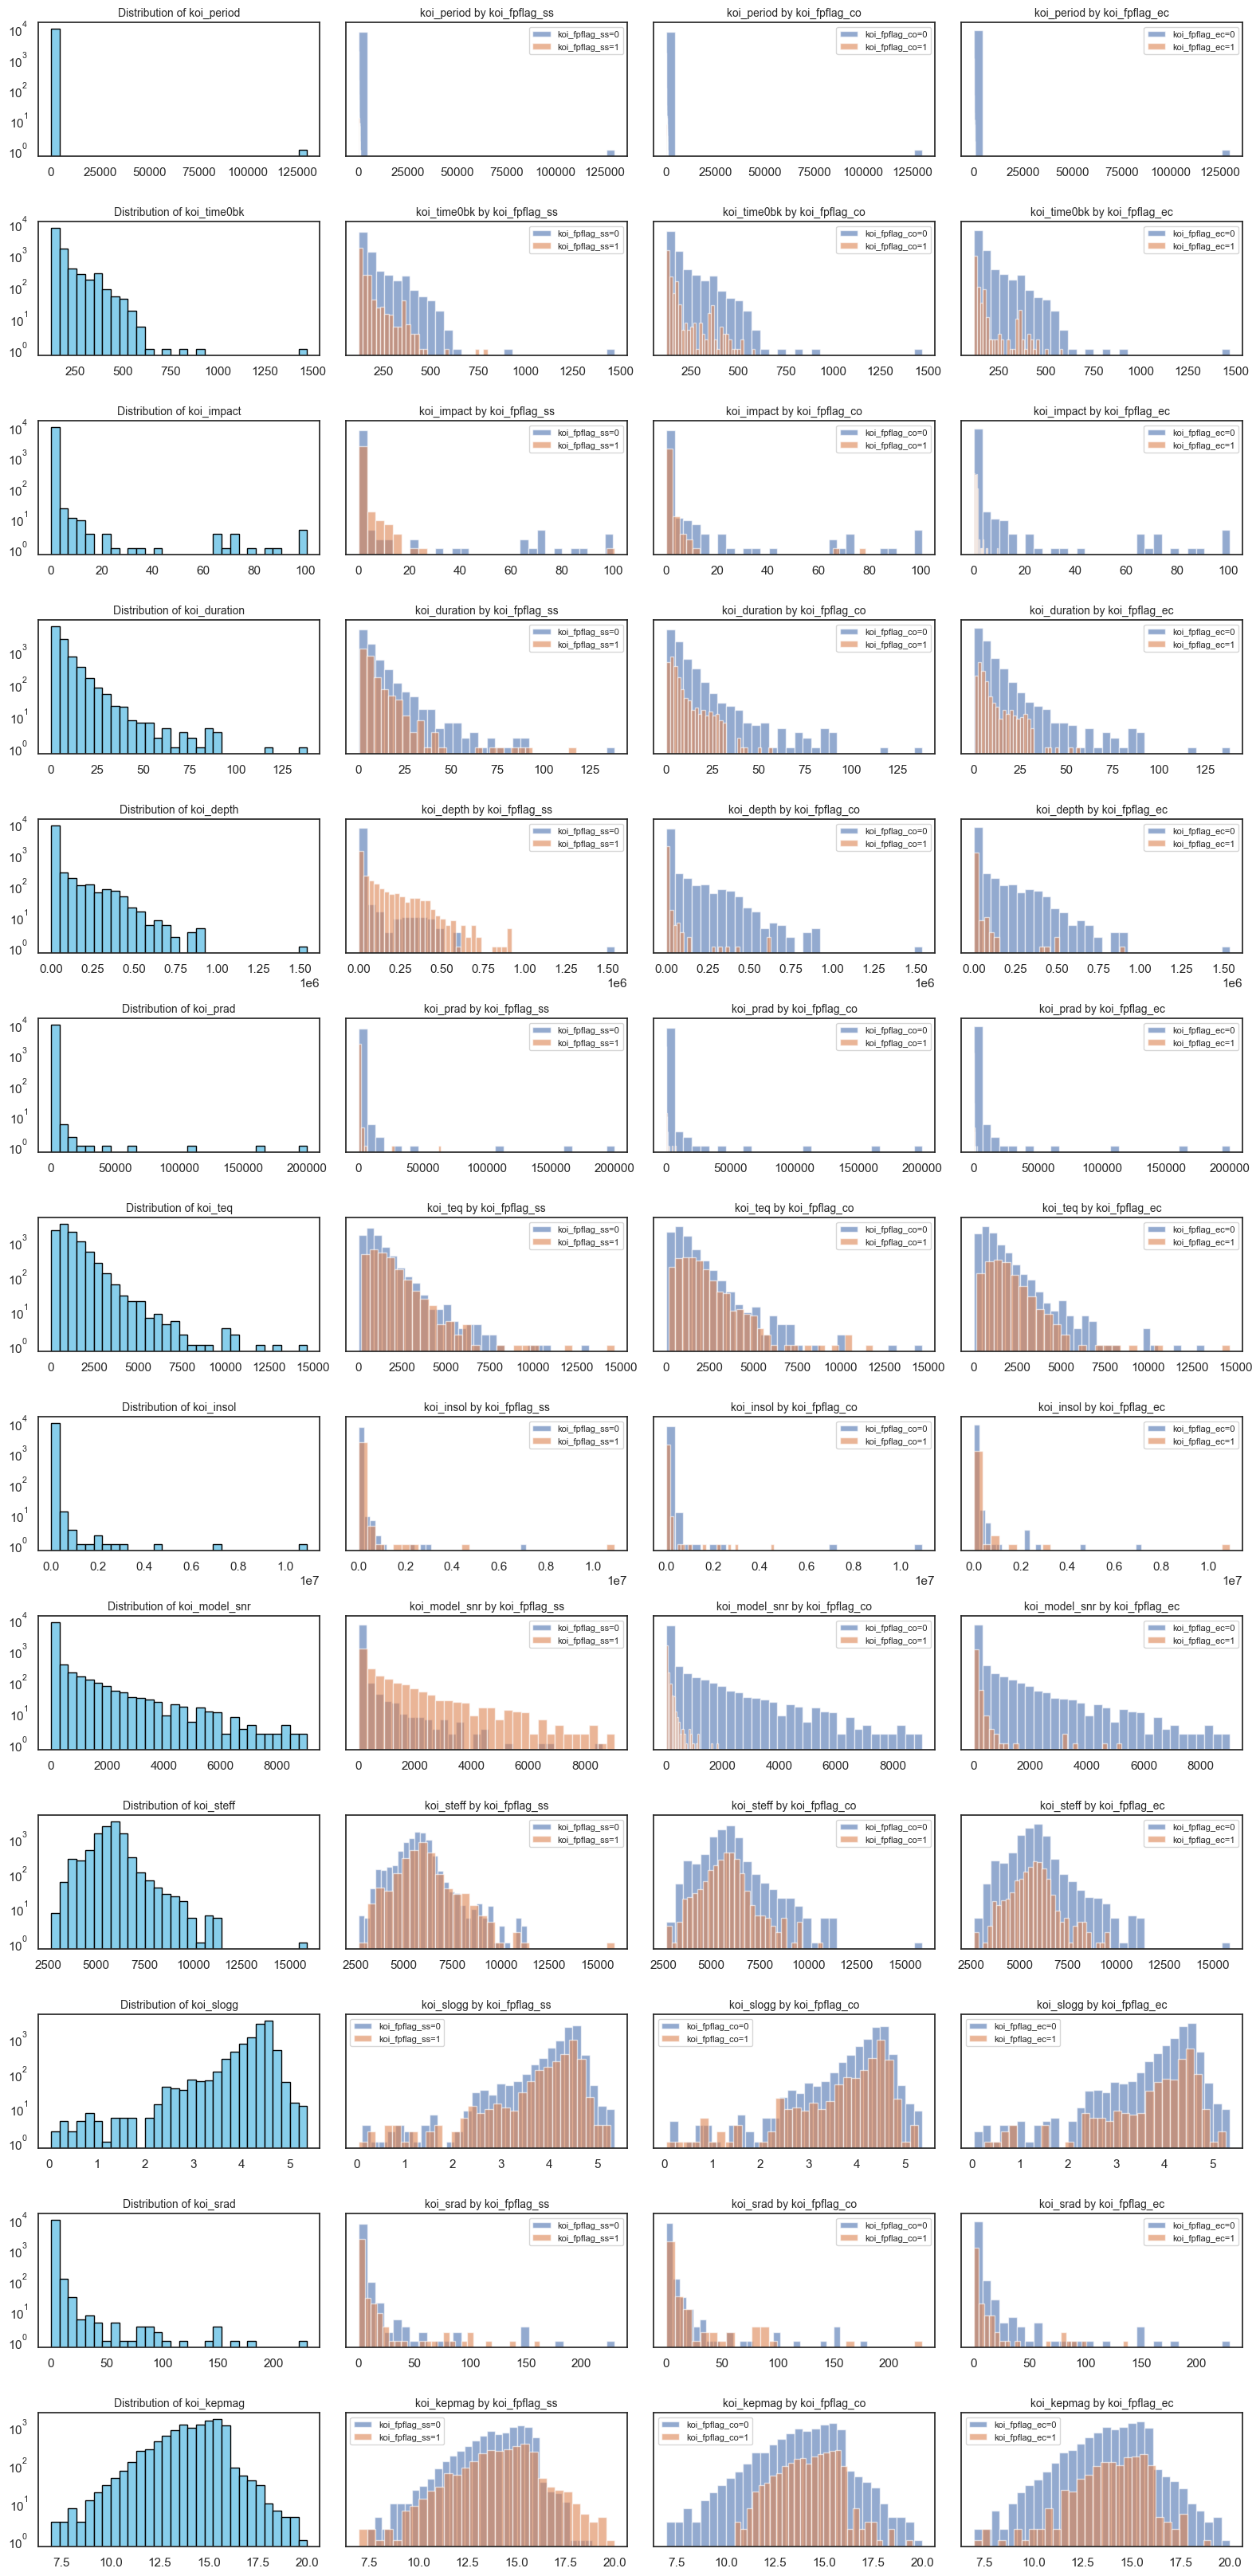

In [11]:
# 0 and negative values are removed for log scale
numerical_cols = [
    "koi_period",
    "koi_time0bk",
    "koi_impact",
    "koi_duration",
    "koi_depth",
    "koi_prad",
    "koi_teq",
    "koi_insol",
    "koi_model_snr",
    "koi_steff",
    "koi_slogg",
    "koi_srad",
    "koi_kepmag",
]

flag_cols = ["koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec"]

# 13 rows × 4 columns
fig, axs = plt.subplots(
    nrows=len(numerical_cols),
    ncols=4,
    figsize=(16, 2.5 * len(numerical_cols)),
    sharey="row",
    squeeze=False,
)

for i, col in enumerate(numerical_cols):
    # remove non-positive values for log scale
    df_pos = df[df[col] > 0]

    # first column - overall distribution
    ax = axs[i, 0]
    ax.hist(df_pos[col].dropna(), bins=30, color="skyblue", edgecolor="black", log=True)
    ax.set_title(f"Distribution of {col}", fontsize=10)

    # column 2 - 4 - with flags
    for j, flag in enumerate(flag_cols, start=1):
        ax = axs[i, j]
        for val in sorted(df[flag].dropna().unique()):
            subset = df_pos[df_pos[flag] == val][col]
            ax.hist(subset, bins=30, alpha=0.6, label=f"{flag}={val}", log=True)
        ax.legend(fontsize=8)
        ax.set_title(f"{col} by {flag}", fontsize=10)

plt.tight_layout()
plt.show()

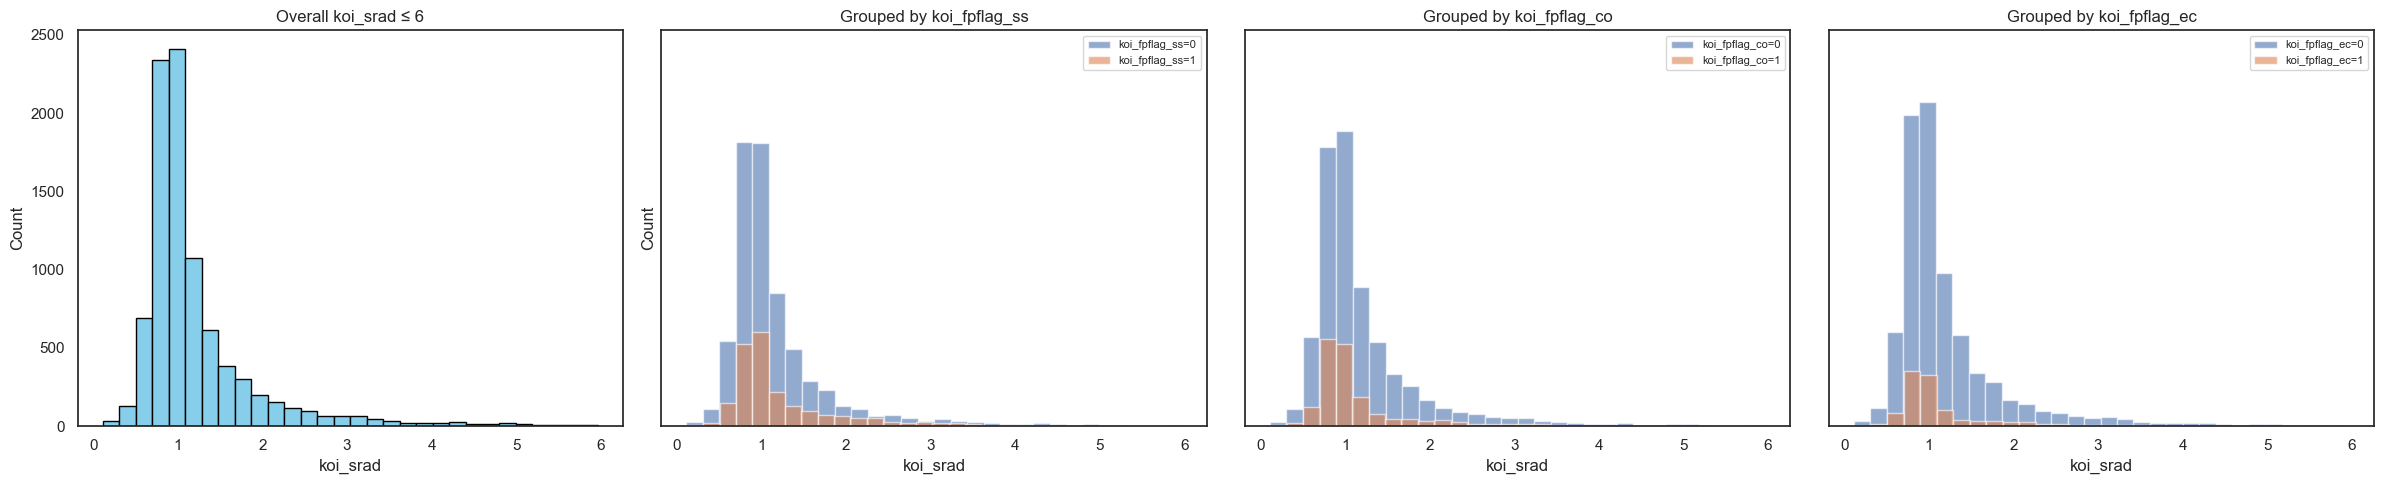

In [12]:
# in case we need to zoom in on a plot
# set a threshold value
data = df["koi_srad"].dropna()
threshold = 6
subset = df[df["koi_srad"] <= threshold]

flag_cols = ["koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec"]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24, 5), sharey=True)

# first column - overall distribution
axs[0].hist(subset["koi_srad"], bins=30, color="skyblue", edgecolor="black")
axs[0].set_title(f"Overall koi_srad ≤ {threshold}")
axs[0].set_xlabel("koi_srad")
axs[0].set_ylabel("Count")

# column 2 - 4 - with flags
for j, flag in enumerate(flag_cols, start=1):
    ax = axs[j]
    for val in subset[flag].dropna().unique():
        sub_flag = subset[subset[flag] == val]["koi_srad"]
        ax.hist(sub_flag, bins=30, alpha=0.6, label=f"{flag}={val}")
    ax.set_title(f"Grouped by {flag}")
    ax.set_xlabel("koi_srad")
    if j == 1:
        ax.set_ylabel("Count")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

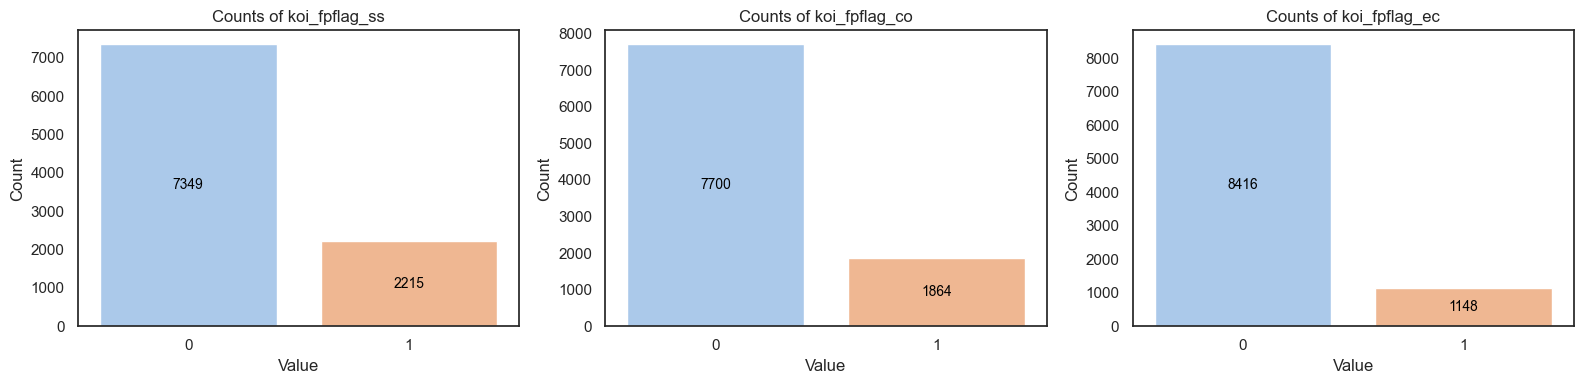

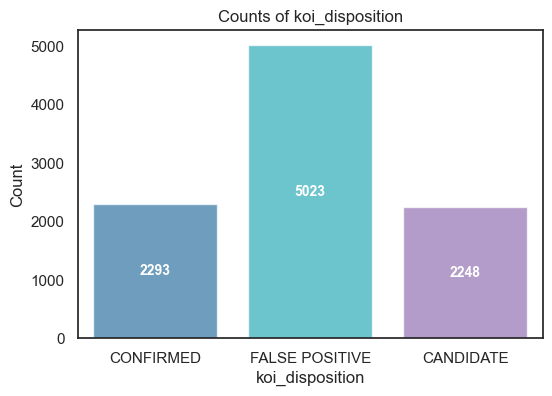

In [13]:
flag_cols = ["koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec"]
dispo_col = "koi_disposition"

# counts for flags
fig, axs = plt.subplots(1, len(flag_cols), figsize=(16, 4))
for i, col in enumerate(flag_cols):
    counts = df[col].value_counts().sort_index()
    sns.barplot(
        x=counts.index.astype(str),
        y=counts.values,
        ax=axs[i],
        hue=counts.index.astype(str),
        palette="pastel",
        legend=False,
    )
    axs[i].set_title(f"Counts of {col}")
    axs[i].set_xlabel("Value")
    axs[i].set_ylabel("Count")

    # Add counts inside bars
    for j, val in enumerate(counts.values):
        axs[i].text(
            j, val / 2, str(val), ha="center", va="center", fontsize=10, color="black"
        )

plt.tight_layout()
plt.show()

# counts for koi_disposition
plt.figure(figsize=(6, 4))
counts = (
    df[dispo_col].value_counts().reindex(["CONFIRMED", "FALSE POSITIVE", "CANDIDATE"])
)
sns.barplot(
    x=counts.index,
    y=counts.values,
    palette={
        "CONFIRMED": "#1f77b4",
        "FALSE POSITIVE": "#17becf",
        "CANDIDATE": "#9467bd",
    },
    hue=counts.index,
    legend=False,
    alpha=0.7,
)

# Add counts inside bars
for j, val in enumerate(counts.values):
    plt.text(
        j,
        val / 2,
        str(val),
        ha="center",
        va="center",
        fontsize=10,
        color="white",
        fontweight="bold",
    )

plt.title("Counts of koi_disposition")
plt.xlabel("koi_disposition")
plt.ylabel("Count")
plt.show()

# Data Cleaning

Data is preprocessed to remove all null values. Since we have sufficient data, we opt to remove rows with null values rather than imputing the missing data, which could influence our results.

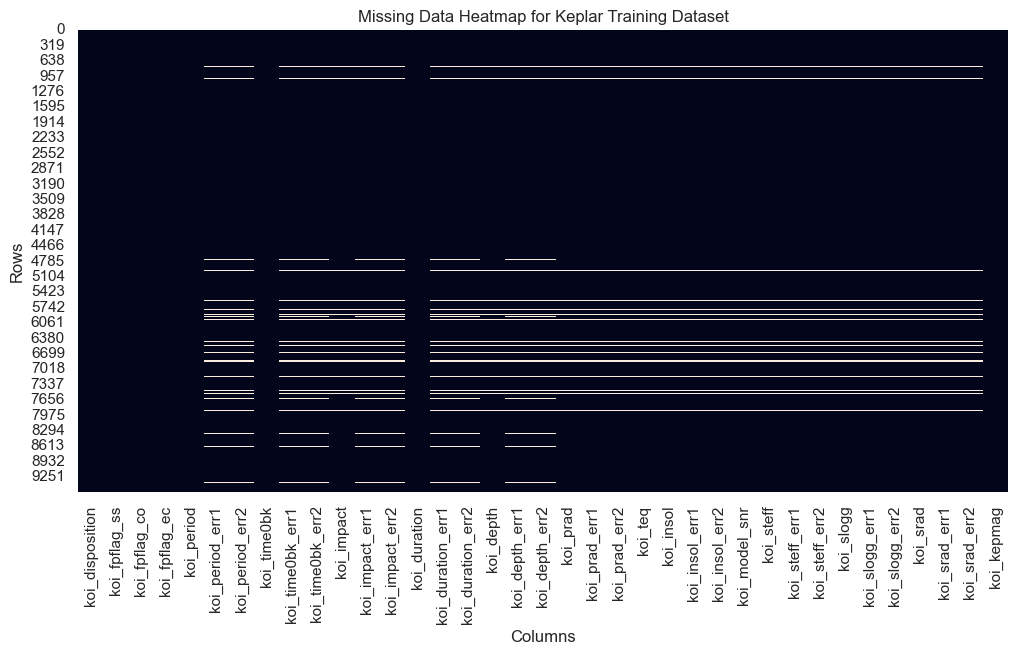

In [14]:
# Visualize missing data
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False)

plt.title("Missing Data Heatmap for Keplar Training Dataset")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [15]:
# Take totals before data cleaning
before_total = len(df)
before = (
    df["koi_disposition"]
    .value_counts()
    .reindex(["CONFIRMED", "FALSE POSITIVE", "CANDIDATE"], fill_value=0)
)

# Drop any row that has a null value
cleaned = df.dropna()

# Take totals after data cleaning
after_total = len(cleaned)
after = (
    cleaned["koi_disposition"]
    .value_counts()
    .reindex(["CONFIRMED", "FALSE POSITIVE", "CANDIDATE"], fill_value=0)
)

# Summary dataframe to display
summary = pd.DataFrame({"Before": before, "After": after})
summary["Before_%"] = (summary["Before"] / before_total * 100).round(2)
summary["After_%"] = (summary["After"] / after_total * 100).round(2)

print(f"Rows before cleaning: {before_total}")
print(f"Rows after cleaning:  {after_total}")
display(summary)

Rows before cleaning: 9564
Rows after cleaning:  8992


,Before,After,Before_%,After_%
koi_disposition,,,,
CONFIRMED,2293,2279,23.98,25.34
FALSE POSITIVE,5023,4550,52.52,50.60
CANDIDATE,2248,2163,23.50,24.05


In [16]:
# Reassign cleaned to df to keep things simple
df = cleaned.copy()

df.shape

(8992, 37)

# Feature Selection
To reduce the number of features we feed into our model, we'll combine the error columns for each feature with uncertainty into a single column, by taking the average absolute error.

In [17]:
# Creates a new dataframe with the error terms collapsed into one column for each feature
def add_err_col(new_df, df, features_with_err):
    aug_df = new_df.copy()
    for f in features_with_err:
        err = (df[f"{f}_err1"].abs() + df[f"{f}_err2"].abs()) / 2
        aug_df[f"{f}_err"] = err
    return aug_df

In [18]:
# All features with associated error terms
features_with_err = [
    "koi_period",
    "koi_time0bk",
    "koi_impact",
    "koi_duration",
    "koi_depth",
    "koi_prad",
    "koi_insol",
    "koi_steff",
    "koi_slogg",
    "koi_srad",
]
# Other physical features to include in the model
other_features = ["koi_teq", "koi_model_snr", "koi_kepmag"]
# Kepler flags to investigate
kepler_flags = ["koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec"]

target = "koi_disposition"

# Create a base df with just the features and target (no errors yet)
base_df = df[features_with_err + other_features + kepler_flags + [target]]
print("Base data frame: ", base_df.shape)

# augment the df with the error terms -- we expect to have 10 more columns now
aug_df = add_err_col(base_df, df, features_with_err)
print("Augmented data frame: ", aug_df.shape)

display(aug_df.head())

Base data frame:  (8992, 17)
Augmented data frame:  (8992, 27)


,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_insol,koi_steff,koi_slogg,koi_srad,...,koi_period_err,koi_time0bk_err,koi_impact_err,koi_duration_err,koi_depth_err,koi_prad_err,koi_insol_err,koi_steff_err,koi_slogg_err,koi_srad_err
0,9.488036,170.538750,0.146,2.95750,615.8,2.26,93.59,5455.0,4.467,0.927,...,2.775000e-05,0.002160,0.2320,0.08190,19.5,0.205,23.050,81.0,0.0800,0.0830
1,54.418383,162.513840,0.586,4.50700,874.8,2.83,9.11,5455.0,4.467,0.927,...,2.479000e-04,0.003520,0.2510,0.11600,35.5,0.255,2.245,81.0,0.0800,0.0830
2,19.899140,175.850252,0.969,1.78220,10829.0,14.60,39.30,5853.0,4.544,0.868,...,1.494000e-05,0.000581,2.6015,0.03410,171.0,2.615,20.765,167.0,0.1100,0.1555
3,1.736952,170.307565,1.276,2.40641,8079.2,33.46,891.96,5805.0,4.564,0.791,...,2.630000e-07,0.000115,0.1035,0.00537,12.8,5.665,449.650,165.5,0.1105,0.1340
4,2.525592,171.595550,0.701,1.65450,603.3,2.75,926.16,6031.0,4.438,1.046,...,3.761000e-06,0.001130,0.3565,0.04200,16.9,0.615,594.285,190.0,0.1400,0.2335


# Model Training
We train four models total:
1. Random Forest Classifier, using Kepler data without flags
2. XGBoost Classifier, using Kepler data without flags
3. Random Forest Classifier, using Kepler data with flags
4. XGBoost Classifier, using Kepler data with flags

Models are tuned using `RandomizedSearchCV()` for Random Forests...

In [19]:
X = aug_df.drop(target, axis=1)
y = aug_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Create training and test sets without the Kepler flags, as we don't use them for the first two models
X_train_no_flag = X_train.drop(kepler_flags, axis=1)
X_test_no_flag = X_test.drop(kepler_flags, axis=1)

## Model 1: Random Forest Classifier Trained on Kepler Data without Flags

In [20]:
# Prints out mean cross-validation scores of the best performing model
def cv_model_eval(cv_results: dict, best_index: int):
    cv_results_df = pd.DataFrame(cv_results)

    mean_accuracy = cv_results_df["mean_test_accuracy"].values[best_index]
    mean_precision = cv_results_df["mean_test_precision_weighted"].values[best_index]
    mean_recall = cv_results_df["mean_test_recall_weighted"].values[best_index]
    mean_f1 = cv_results_df["mean_test_f1_weighted"].values[best_index]

    print(f"Mean CV accuracy of best model: {mean_accuracy:.4f}")
    print(f"Mean CV precision of best model: {mean_precision:.4f}")
    print(f"Mean CV recall of best model: {mean_recall:.4f}")
    print(f"Mean CV f1 score of best model: {mean_f1:.4f}")

In [21]:
# TODO: set up param grid for RandomizedSearchCV
# Determine which parameters to optimize over which space
# We can use the same param grid for both RandomForests that we train
# rf_param_grid = {
#    "n_estimators": [500],
#    "max_depth": [12],
#    "min_samples_split": [2],
#    "max_features": ["sqrt"],
# }

rf_param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False],
    "class_weight": ["balanced", None],
}

# Use 5-fold cross validation to determine optimal params
# Use weighted averages for scoring since we have class imbalance
rf_no_flags_cv = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=4),
    param_distributions=rf_param_grid,
    cv=5,
    scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"],
    refit="accuracy",
    random_state=42,
    n_iter=15,
)
rf_no_flags_cv.fit(X_train_no_flag, y_train)

# Show best hyperparameters
print("Best hyperparameters: ", rf_no_flags_cv.best_params_)

# Print out best model's scores
cv_model_eval(rf_no_flags_cv.cv_results_, rf_no_flags_cv.best_index_)

# RandomizedSearchCV will refit the best model on all the training data
# Use this best model to evaluate on the test data
rf_no_flags_model = rf_no_flags_cv.best_estimator_

Best hyperparameters:  {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': None, 'bootstrap': False}
Mean CV accuracy of best model: 0.7742
Mean CV precision of best model: 0.7641
Mean CV recall of best model: 0.7742
Mean CV f1 score of best model: 0.7649


Text(0.5, 1.0, 'Feature Importance Plot for Model 1')

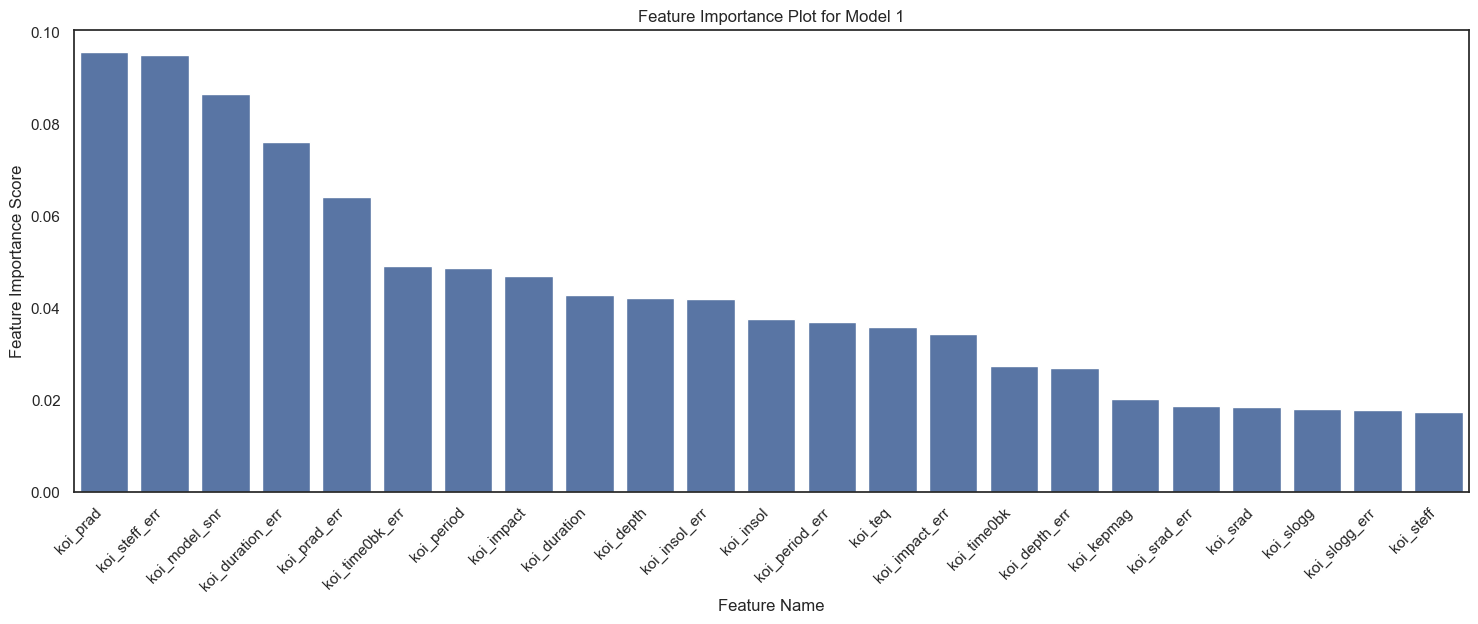

In [22]:
# Create a feature importance plot for the best model
feature_importances = rf_no_flags_model.feature_importances_
feature_names = X_train_no_flag.columns

feature_importance_series = pd.Series(feature_importances, index=feature_names)
feature_importance_series.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(18, 6))
sns.barplot(y=feature_importance_series.values, x=feature_importance_series.index)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature Name")
plt.ylabel("Feature Importance Score")
plt.title("Feature Importance Plot for Model 1")

## Model 2: Random Forest Classifier Trained on Kepler Data with Flags

In [23]:
# Use 5-fold cross validation to determine optimal params
# Use weighted averages for scoring since we have class imbalance
rf_with_flags_cv = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=4),
    param_distributions=rf_param_grid,
    cv=5,
    scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"],
    refit="accuracy",
    random_state=42,
    n_iter=15,
)
rf_with_flags_cv.fit(X_train, y_train)

# Show best hyperparameters
print("Best hyperparameters: ", rf_with_flags_cv.best_params_)

# Print out mean cross-validated scores
cv_model_eval(rf_with_flags_cv.cv_results_, rf_with_flags_cv.best_index_)

# RandomizedSearchCV will refit the best model on all the training data
# Use this best model to evaluate on the test data
rf_with_flags_model = rf_with_flags_cv.best_estimator_

Best hyperparameters:  {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced', 'bootstrap': False}
Mean CV accuracy of best model: 0.8387
Mean CV precision of best model: 0.8330
Mean CV recall of best model: 0.8387
Mean CV f1 score of best model: 0.8343


Text(0.5, 1.0, 'Feature Importance Plot for Model 2')

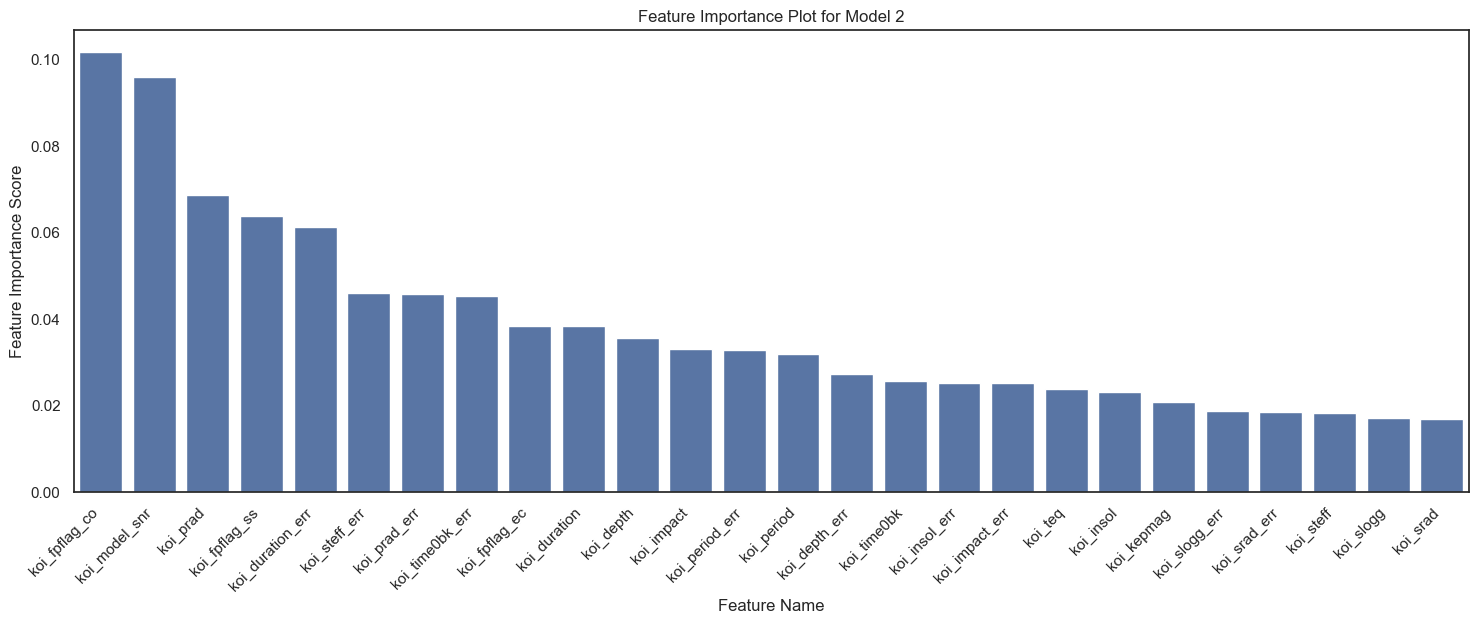

In [24]:
# Create a feature importance plot for the best model
feature_importances = rf_with_flags_model.feature_importances_
feature_names = X_train.columns

feature_importance_series = pd.Series(feature_importances, index=feature_names)
feature_importance_series.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(18, 6))
sns.barplot(y=feature_importance_series.values, x=feature_importance_series.index)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature Name")
plt.ylabel("Feature Importance Score")
plt.title("Feature Importance Plot for Model 2")

We can see that the most important feature to the model is `koi_fpflag_co`, and the third most important feature is `koi_fpflag_ss`.

## Model 3: XGBoost Trained on Kepler Data Without Flags

In [25]:
# XGBoost requires our labels to be encoded numerically
le = LabelEncoder()
le.fit(y_train)
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

In [26]:
# TODO: set up param grid for RandomizedSearchCV
# Determine which parameters to optimize over which space
# We can use the same param grid for both RandomForests that we train
# xgb_param_grid = {
#    "n_estimators": [500],
#    "max_depth": [6],
#    "learning_rate": [0.05],
#    "subsample": [0.5],
#    "colsample_bytree": [0.8],
# }

# xgb_param_grid = {
#     "subsample": [0.8, 0.9, 1.0],
#     "reg_lambda": [1.0, 1.5, 2.0],
#     "reg_alpha": [0.5, 1, 1.5],
#     "n_estimators": [80, 100, 150, 200],
#     "min_child_weight": [8, 10, 12],
#     "max_depth": [8, 10, 12],
#     "learning_rate": [0.05, 0.075, 0.1, 0.15],
#     "gamma": [0, 0.2, 0.5],
#     "colsample_bytree": [0.7, 0.8, 0.9],
# }

# Best hyperparameters:  {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 1, 'n_estimators': 100, 'min_child_weight': 12, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.8}
# Mean CV accuracy of best model: 0.7745
# Mean CV precision of best model: 0.7651
# Mean CV recall of best model: 0.7745
# Mean CV f1 score of best model: 0.7670

# xgb_param_grid = {
#     "subsample": [0.7, 0.8, 0.9, 1.0],
#     "reg_lambda": [1.5, 2.0, 2.5, 3.0],
#     "reg_alpha": [1.0, 1.5, 2.0],
#     "n_estimators": [60, 80, 100, 120, 150],
#     "min_child_weight": [10, 12, 14, 16],
#     "max_depth": [8, 10, 12, 14],
#     "learning_rate": [0.05, 0.075, 0.1, 0.125],
#     "gamma": [0, 0.2, 0.4, 0.6],
#     "colsample_bytree": [0.6, 0.7, 0.8],
# }

# Best hyperparameters:  {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 2.0, 'n_estimators': 150, 'min_child_weight': 16, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}
# Mean CV accuracy of best model: 0.7741
# Mean CV precision of best model: 0.7642
# Mean CV recall of best model: 0.7741
# Mean CV f1 score of best model: 0.7663

xgb_param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [4, 6, 10, 20],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.5, 0.7, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "min_child_weight": [1, 5, 10],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [1, 1.5, 2],
}

# Use 5-fold cross validation to determine optimal params
# Use weighted averages for scoring since we have class imbalance
xgb_no_flags_cv = RandomizedSearchCV(
    XGBClassifier(random_state=42, objective="multi:softmax", num_class=3, nthread=4),
    param_distributions=xgb_param_grid,
    cv=5,
    scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"],
    refit="accuracy",
    random_state=42,
    n_iter=15,
    # verbose=2,
)
xgb_no_flags_cv.fit(X_train_no_flag, y_train_encoded)

# Show best hyperparameters
print("Best hyperparameters: ", xgb_no_flags_cv.best_params_)

# Print out mean cross-validated scores
cv_model_eval(xgb_no_flags_cv.cv_results_, xgb_no_flags_cv.best_index_)

# RandomizedSearchCV will refit the best model on all the training data
# Use this best model to evaluate on the test data
xgb_no_flags_model = xgb_no_flags_cv.best_estimator_

Best hyperparameters:  {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.6}
Mean CV accuracy of best model: 0.7773
Mean CV precision of best model: 0.7675
Mean CV recall of best model: 0.7773
Mean CV f1 score of best model: 0.7692


Text(0.5, 1.0, 'Feature Importance Plot for Model 3')

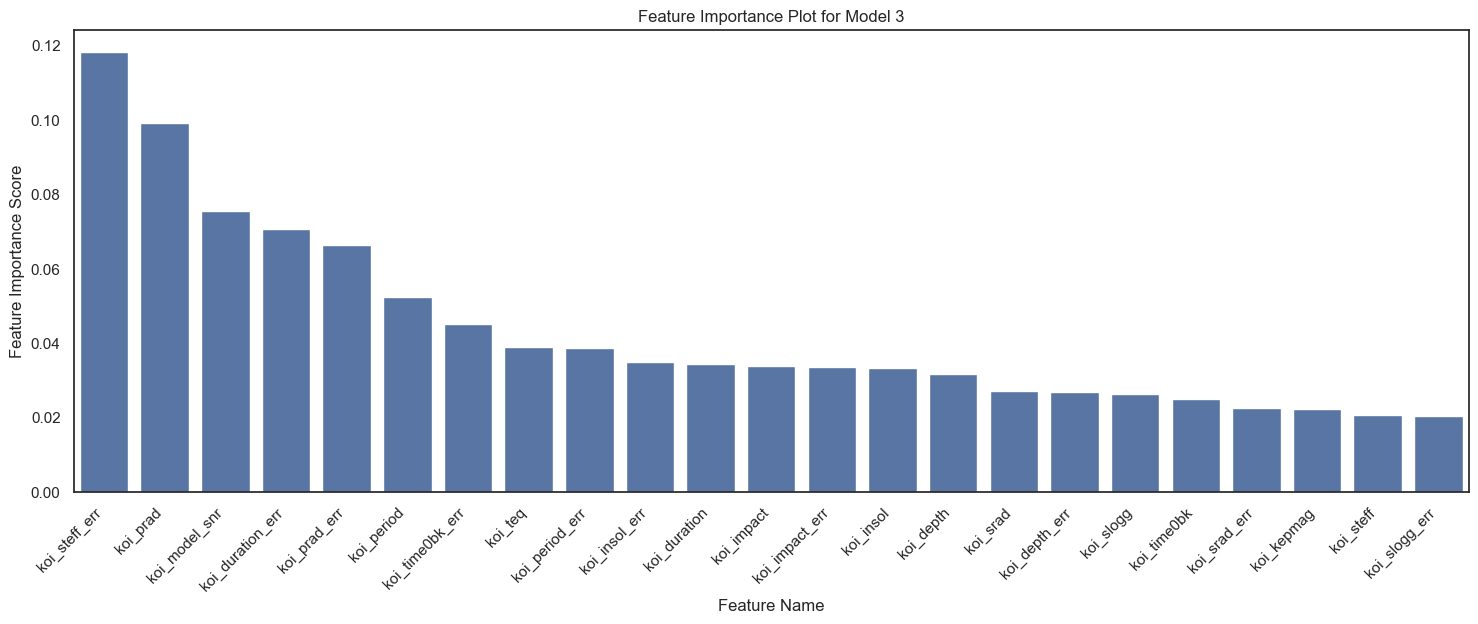

In [27]:
# Create a feature importance plot for the best model
feature_importances = xgb_no_flags_model.feature_importances_
feature_names = X_train_no_flag.columns

feature_importance_series = pd.Series(feature_importances, index=feature_names)
feature_importance_series.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(18, 6))
sns.barplot(y=feature_importance_series.values, x=feature_importance_series.index)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature Name")
plt.ylabel("Feature Importance Score")
plt.title("Feature Importance Plot for Model 3")

## Model 4: XGBoost Trained on Kepler Data With Flags

In [28]:
# Use 5-fold cross validation to determine optimal params
# Use weighted averages for scoring since we have class imbalance
xgb_with_flags_cv = RandomizedSearchCV(
    XGBClassifier(random_state=42, objective="multi:softmax", num_class=3, nthread=4),
    param_distributions=xgb_param_grid,
    cv=5,
    scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"],
    refit="accuracy",
    random_state=42,
    n_iter=15,
)
xgb_with_flags_cv.fit(X_train, y_train_encoded)

# Show best hyperparameters
print("Best hyperparameters: ", xgb_with_flags_cv.best_params_)

# Print out mean cross-validated scores
cv_model_eval(xgb_with_flags_cv.cv_results_, xgb_with_flags_cv.best_index_)

# RandomizedSearchCV will refit the best model on all the training data
# Use this best model to evaluate on the test data
xgb_with_flags_model = xgb_with_flags_cv.best_estimator_

Best hyperparameters:  {'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.6}
Mean CV accuracy of best model: 0.8425
Mean CV precision of best model: 0.8380
Mean CV recall of best model: 0.8425
Mean CV f1 score of best model: 0.8388


Text(0.5, 1.0, 'Feature Importance Plot for Model 4')

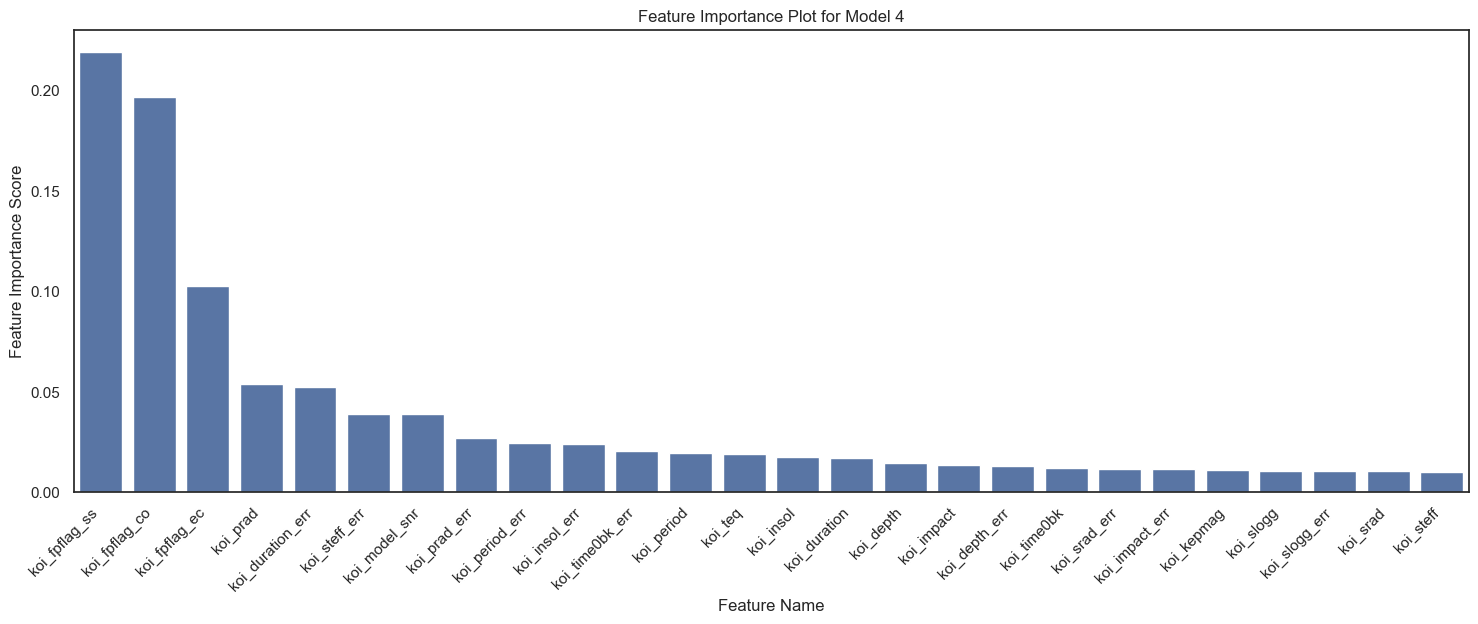

In [29]:
# Create a feature importance plot for the best model
feature_importances = xgb_with_flags_model.feature_importances_
feature_names = X_train.columns

feature_importance_series = pd.Series(feature_importances, index=feature_names)
feature_importance_series.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(18, 6))
sns.barplot(y=feature_importance_series.values, x=feature_importance_series.index)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature Name")
plt.ylabel("Feature Importance Score")
plt.title("Feature Importance Plot for Model 4")

In this case, the three flags make up the most important features, with their significance all scored markedly higher than the other features.

# Test Results
Report these for the model we choose based on the cross-validation scores

In [30]:
# Model 1 test results
y_pred_rf_no_flags = rf_no_flags_model.predict(X_test_no_flag)

# TODO: We might need to add a ROC AUC plot and other metrics
# A confusion matrix might be a good addition???
print("Results on test data:")
print(classification_report(y_test, y_pred_rf_no_flags))

Results on test data:
                precision    recall  f1-score   support

     CANDIDATE       0.64      0.47      0.54       433
     CONFIRMED       0.77      0.84      0.80       456
FALSE POSITIVE       0.83      0.90      0.86       910

      accuracy                           0.78      1799
     macro avg       0.75      0.74      0.74      1799
  weighted avg       0.77      0.78      0.77      1799



In [31]:
# Model 2 test results
y_pred_rf_with_flags = rf_with_flags_model.predict(X_test)

# TODO: We might need to add a ROC AUC plot and other metrics
# A confusion matrix might be a good addition???
print("Results on test data:")
print(classification_report(y_test, y_pred_rf_with_flags))

Results on test data:
                precision    recall  f1-score   support

     CANDIDATE       0.75      0.63      0.68       433
     CONFIRMED       0.82      0.86      0.84       456
FALSE POSITIVE       0.91      0.96      0.94       910

      accuracy                           0.85      1799
     macro avg       0.83      0.81      0.82      1799
  weighted avg       0.85      0.85      0.85      1799



In [32]:
# Model 3 test results
y_pred_xgb_no_flags = xgb_no_flags_model.predict(X_test_no_flag)

# TODO: We might need to add a ROC AUC plot and other metrics
# A confusion matrix might be a good addition???
print("Results on test data:")
print(
    classification_report(
        y_test_encoded,
        y_pred_xgb_no_flags,
        target_names=le.inverse_transform([0, 1, 2]),
    )
)

Results on test data:
                precision    recall  f1-score   support

     CANDIDATE       0.65      0.49      0.56       433
     CONFIRMED       0.78      0.84      0.81       456
FALSE POSITIVE       0.84      0.91      0.87       910

      accuracy                           0.79      1799
     macro avg       0.76      0.75      0.75      1799
  weighted avg       0.78      0.79      0.78      1799



In [33]:
# Model 4 test results
y_pred_xgb_with_flags = xgb_with_flags_model.predict(X_test)

# TODO: We might need to add a ROC AUC plot and other metrics
# A confusion matrix might be a good addition???
print("Results on test data:")
print(
    classification_report(
        y_test_encoded,
        y_pred_xgb_with_flags,
        target_names=le.inverse_transform([0, 1, 2]),
    )
)

Results on test data:
                precision    recall  f1-score   support

     CANDIDATE       0.76      0.64      0.70       433
     CONFIRMED       0.82      0.86      0.84       456
FALSE POSITIVE       0.92      0.97      0.95       910

      accuracy                           0.86      1799
     macro avg       0.83      0.82      0.83      1799
  weighted avg       0.86      0.86      0.86      1799



<Figure size 700x600 with 0 Axes>

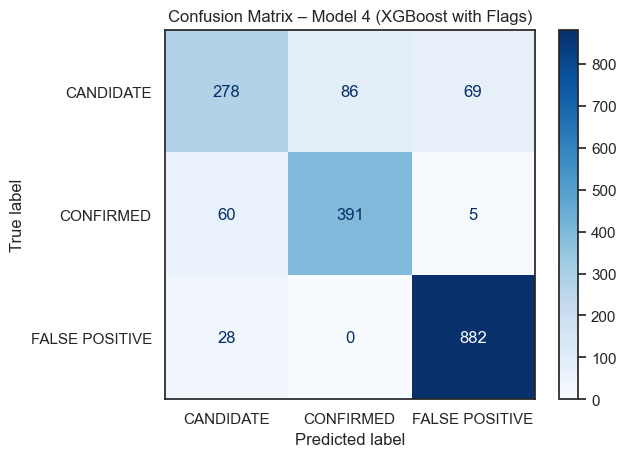

In [39]:
#Confusion Matrix based on Model 4
cm = confusion_matrix(y_test_encoded, y_pred_xgb_with_flags)

plt.figure(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.inverse_transform([0, 1, 2]))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Model 4 (XGBoost with Flags)")
plt.show()

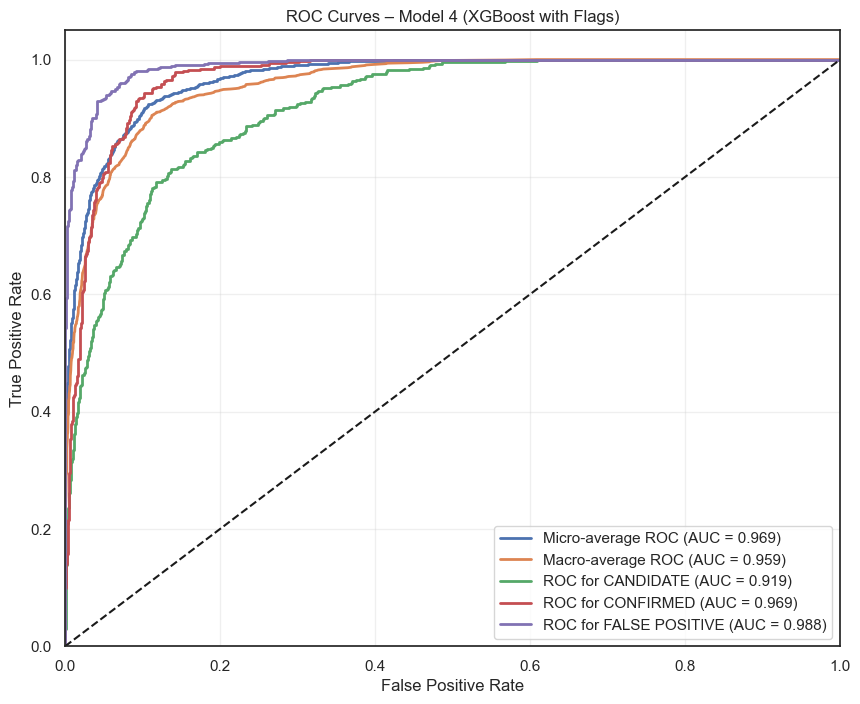

In [40]:
#Set up fpr, tpr, and roc
classes = [0, 1, 2]
y_test_bin = label_binarize(y_test_encoded, classes=classes)
n_classes = y_test_bin.shape[1]
y_proba = xgb_with_flags_model.predict_proba(X_test)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 8))

# Micro ROC
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC (AUC = {roc_auc['micro']:.3f})",
         linewidth=2)

# Macro ROC
plt.plot(fpr["macro"], tpr["macro"],
         label=f"Macro-average ROC (AUC = {roc_auc['macro']:.3f})",
         linewidth=2)

# Class-specific ROC curves
class_names = le.inverse_transform([0, 1, 2])

for i, cname in zip(range(n_classes), class_names):
    plt.plot(fpr[i], tpr[i], linewidth=2,
             label=f"ROC for {cname} (AUC = {roc_auc[i]:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Model 4 (XGBoost with Flags)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
